## The heat equation in a 1D Cartesian system (Dirichlet BC)

We compare the FVM solution by PyFVTool to the analytic solutions, for two different types of boundary conditions.

In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
import pyfvtool as pf

In [2]:
# Spoiler alert!

def T_analytic_dirichlet(x,t, alfa, T0, Ts):
    return (T0-Ts)*erf(x/np.sqrt(4*alfa*t))+Ts

def T_analytic_neumann(x,t, alfa, T0, k, qs):
    return T0 + qs/k*np.sqrt(4*alfa*t/np.pi)*np.exp(-x**2/(4*alfa*t))\
              - qs/k*x*(1-erf(x/np.sqrt(4*alfa*t)))

In [3]:
# Parameters
L = 1.0 # [m] domain length
k = 20.0 # 0.6 for water, 0.025 for air W/m/K
rho = 8000.0 # kg/m^3
c = 500.0 # J/kg/K (4200 for water, 1000 for air)
alfa = k/(rho*c) # heat diffusion
T0 = 300.0 # [K]
Ts = 350.0 # [K]
qs = 1000 # [W/m^2]
t_sim = L**2/(20*alfa) # [s]
time_steps = 50
dt = t_sim/time_steps # 
Nx = 50 # number of cells

In [4]:
m = pf.Grid1D(Nx, L)

In [5]:
# Boundary condition
left_bc = "Dirichlet"

BC = pf.BoundaryConditions(m)
if left_bc == "Dirichlet":
    BC.left.a[:] = 0.0
    BC.left.b[:] = 1.0
    BC.left.c[:] = Ts
    T_analytic = lambda x,t: T_analytic_dirichlet(x, t, alfa, T0, Ts)
else:
    BC.left.a[:] = k
    BC.left.b[:] = 0.0
    BC.left.c[:] = -qs
    T_analytic = lambda x,t: T_analytic_neumann(x, t, alfa, T0, k, qs)

In [6]:
# Initial condition
T_init = pf.CellVariable(m, T0, BC) # initial condition

In [7]:
# physical parameters
alfa_cell = pf.CellVariable(m, alfa, pf.BoundaryConditions(m))
alfa_face = pf.harmonicMean(alfa_cell)

In [8]:
M_diff = pf.diffusionTerm(alfa_face)
[M_bc, RHS_bc] = pf.boundaryConditionsTerm(BC)

In [9]:
t=0
while t<t_sim:
    t +=dt
    [M_trans, RHS_trans] = pf.transientTerm(T_init, dt, 1.0)
    T_val = pf.solveMatrixPDE(m, M_bc+M_trans-M_diff, RHS_bc+RHS_trans)
    T_init.update_value(T_val)

In [10]:
x = m.facecenters.x
T_face = pf.linearMean(T_val)
T_num = T_face.xvalue
T_an = T_analytic(x, t_sim)

In [11]:
er = np.sum(np.abs(T_num-T_an)/T_an)/Nx
print(er)

0.00021832771380885904


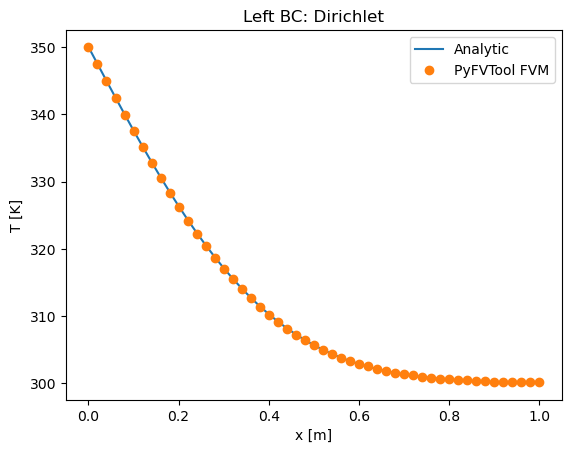

In [12]:
plt.figure(1)
plt.clf()
plt.title('Left BC: '+left_bc)
plt.plot(x, T_an, x, T_num, 'o')
plt.legend({'Analytic', 'PyFVTool FVM'})
plt.xlabel('x [m]')
plt.ylabel('T [K]')
plt.show()